 ## NBA Neural Network - in prog

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.spatial.distance import cdist
from numpy.linalg import inv
from sklearn.kernel_ridge import KernelRidge
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pandas.plotting import scatter_matrix
from IPython.display import display
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pymc3 as pm
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn
from sklearn.neural_network import MLPClassifier

/Users/Sachin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [43]:
# training data
player_training_data  = []
for i in range(27):
    df = pd.read_csv('2014-draft-class/player{}.csv'.format(i))
    df = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
    player_training_data.append(df)

display(player_training_data[24].head())

#test data
player_test_data = []

for i in range(27):
    df = pd.read_csv('2014-draft-class/player2019_{}.csv'.format(i))
    df = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
    player_test_data.append(df)

# display(player_test_data[24].head())
    

,G,Date,Age,Opp,GS,MP,FG,FGA,FG_Perc,3P,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,2015,20,74.33,0,3,1,1,1.000,0,...,0,0,0,0,0,1,0,2,0.7,1
1,2,2015,20,89.27,0,18,5,8,0.625,0,...,6,9,1,0,0,2,3,10,7.8,10
2,3,2015,20,51.92,0,24,4,9,0.444,0,...,1,4,0,0,0,1,2,8,3.9,-2
3,4,2015,20,40.71,0,17,1,4,0.250,0,...,2,3,0,0,1,1,1,5,2.8,-6
4,5,2015,20,37.13,0,17,2,4,0.500,0,...,2,4,1,1,1,1,1,4,4.2,-5


In [3]:
# prepare training data for one player (jokic)
train = player_training_data[24]
train = train[train.PTS != 0]
train = train['PTS'].apply(pd.to_numeric, errors='coerce')
y = np.array(train).flatten()
y_hat = y[3:]
x_features = []
for k in range (3,len(y)):
    temp = np.ones(3)
    for j in range(3):
        temp[j] = y[k-(j+1)]
    x_features.append(temp)
games = np.arange(4, 4 + len(y_hat))
x_cols = np.column_stack((games, x_features))

In [4]:
#prepare test data
test = player_test_data[24]
test = test[test.PTS != 0]
test = test['PTS'].apply(pd.to_numeric, errors='coerce')
y_tst = np.array(test).flatten()
y_hat_tst = y_tst[3:]
x_tst = []
for k in range (3,len(y_tst)):
    temp = np.ones(3)
    for j in range(3):
        temp[j] = y_tst[k-(j+1)]
    x_tst.append(temp)
    
games_tst = np.arange(games[-1] + 4, (games[-1] + 4) + len(y_hat_tst))
x_tst_cols = np.column_stack((games_tst, x_tst))

test = player_test_data[24]
test = test[test.PTS != 0]
features = ['PTS', 'GmSc','FGA']
test = test[features].apply(pd.to_numeric, errors='coerce')

pts = np.array(test.PTS)
gmsc = np.array(test.GmSc)
fga = np.array(test.FGA)
#prev game gmsc
pts_i = pts[1:]
gmsc_prev_i = gmsc[2:-1]
fga_prev_i = fga[2:-1]

x_test = np.column_stack((x_tst_cols, fga_prev_i, gmsc_prev_i))

In [5]:
# y - points for jokic (training data)
train = player_training_data[24]
train = train[train.PTS != 0]
features = ['PTS', 'GmSc']
train = train[features].apply(pd.to_numeric, errors='coerce')

pts = np.array(train.PTS)
gmsc = np.array(train.GmSc)
#prev game gmsc
pts_i = pts[1:]
gmsc_prev_i = gmsc[2:-1]

In [6]:
train = player_training_data[24]
train = train[train.PTS != 0]
features = ['PTS', 'FGA']
train = train[features].apply(pd.to_numeric, errors='coerce')

pts = np.array(train.PTS)
fga = np.array(train.FGA)
#prev game fga
pts_i = pts[1:]
fga_prev_i = fga[2:-1]

In [7]:
x_train = np.column_stack((x_cols, fga_prev_i, gmsc_prev_i))

krr_clf = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.00001, degree=3, coef0=1, kernel_params=None)
clf = krr_clf.fit(x_train, y_hat)

In [8]:
pred = clf.predict(x_test)

rmse = sqrt(mean_squared_error(pred, y_hat_tst))
rmse

8.161850583883512

In [9]:
"""
Multi-feature Kernel Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~

Using the previous game's FGA attempts, previous GmSc,
game no. and the pts scoredfrom the previous 3 games as 
feautures to predict the points scored for the
upcoming game.

"""
a = []
ppg_avg = []
for i in range(len(player_training_data)):
    train = player_training_data[i]
    train = train[train.PTS != 0]
    train = train['PTS'].apply(pd.to_numeric, errors='coerce')
    y = np.array(train).flatten()
    y_hat = y[3:]
    x_features = []
    for k in range (3,len(y)):
        temp = np.ones(3)
        for j in range(3):
            temp[j] = y[k-(j+1)]
        x_features.append(temp)
    games = np.arange(4, 4 + len(y_hat))
    x_cols = np.column_stack((games, x_features))
    
    train = player_training_data[i]
    train = train[train.PTS != 0]
    features = ['PTS', 'GmSc','FGA']
    train = train[features].apply(pd.to_numeric, errors='coerce')

    pts = np.array(train.PTS)
    gmsc = np.array(train.GmSc)
    fga = np.array(train.FGA)
    #prev game gmsc
    pts_i = pts[1:]
    gmsc_prev_i = gmsc[2:-1]
    fga_prev_i = fga[2:-1]
#     opp_cur = opp[3:]

    x_train = np.column_stack((x_cols, fga_prev_i, gmsc_prev_i))
    
    test = player_test_data[i]
    test = test[test.PTS != 0]
    test = test['PTS'].apply(pd.to_numeric, errors='coerce')
    y_tst = np.array(test).flatten()
    y_hat_tst = y_tst[3:]
    x_tst = []
    for k in range (3,len(y_tst)):
        temp = np.ones(3)
        for j in range(3):
            temp[j] = y_tst[k-(j+1)]
        x_tst.append(temp)

    games_tst = np.arange(games[-1] + 4, (games[-1] + 4) + len(y_hat_tst))
    x_tst_cols = np.column_stack((games_tst, x_tst))

    test = player_test_data[i]
    test = test[test.PTS != 0]
    features = ['PTS', 'GmSc','FGA']
    test = test[features].apply(pd.to_numeric, errors='coerce')

    pts = np.array(test.PTS)
    gmsc = np.array(test.GmSc)
    fga = np.array(test.FGA)
    #prev game gmsc
    pts_i = pts[1:]
    gmsc_prev_i = gmsc[2:-1]
    fga_prev_i = fga[2:-1]
#     opp_cur = opp[3:]

    x_test = np.column_stack((x_tst_cols, fga_prev_i, gmsc_prev_i))
    
    krr_clf = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.0000075, degree=3, coef0=1, kernel_params=None)
    clf = krr_clf.fit(x_train, y_hat)
    
    pred = clf.predict(x_test)
    #print(np.round(np.mean(pred),1))
    ppg_avg.append(np.mean(pred))
    rmse = sqrt(mean_squared_error(pred, y_hat_tst))
    print(rmse)
    a.append(rmse)
    
print("Mean RMSE:{}".format(np.mean(a)))
    

7.439250072143263
5.3623942594631115
9.634738429976842
5.9031174355923515
4.458541333594716
5.668882331410884
7.564405245962238
3.5314192848534702
5.00400643472244
5.114844186263214
4.3742101205844826
9.762079412580729
7.82688081048712
6.145931212583639
8.096547416114472
4.298102536229955
6.144929544675248
6.414996549855495
6.7716137021458165
4.6728256288771455
5.734011647156768
8.71335846863423
6.0240066858556025
3.413141725697982
8.157730505442778
5.080603015631238
8.05900622105103
Mean RMSE:6.273021267318009


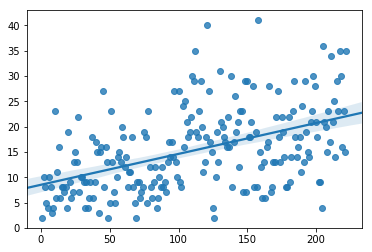

In [260]:
"""
Weighted Least Squares Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~

WLS model, starting with one feature (games played), then build
from there

"""
# player: nikola jokic 
train = player_training_data[24]
train = train[train.PTS != 0]
train = train['PTS']
y = np.array(train)

games_played = np.arange(1, len(train)+1)

x = games_played

sns.regplot(x,y)

In [42]:
## RANDOM STUFF ###
np.set_printoptions(suppress=True)
jokic = player_training_data[24]
jokic = jokic[jokic.PTS != 0]
jokic = jokic.fillna(0)
jokic['GmSc'] = jokic['GmSc'] ** 2
jokic['+/-'] = jokic['+/-'] ** 2
jokic.drop(['PTS'],axis=1)

feature_array = np.array(jokic.drop(['PTS'],axis=1))
feature_array = feature_array[3:]
feature_array.T[0] = np.arange(4,4+len(feature_array))


prev_pts = jokic[jokic.PTS != 0]
prev_pts = prev_pts['PTS'].apply(pd.to_numeric, errors='coerce')
y = np.array(prev_pts).flatten()

y_hat = y[3:]
x_features = []
for k in range (3,len(y)):
    temp = np.ones(3)
    for j in range(3):
        temp[j] = y[k-(j+1)]
    x_features.append(temp)
    
x_features = np.array(x_features)
print(x_features.shape)
print(feature_array.shape)

last_3_games = []
for games in x_features:
    t = np.mean(games)
    last_3_games.append(t)
l3g = np.array(last_3_games)

feature_array.T[1] = l3g

(219, 3)
(219, 25)


In [39]:
#### FINDING BEST FEATURES USNIG SELECT-K-BEST AS WELL AS LOOKING AT PCA ########


import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn import preprocessing

X = pd.DataFrame(feature_array).apply(pd.to_numeric,errors='coerce')
display(X)
data_scaled = pd.DataFrame(preprocessing.scale(X), columns=X.columns)

pca = PCA(n_components=0.8)
pca_ft = pca.fit_transform(data_scaled)

# print(pd.DataFrame(pca.components_,columns=X.columns,index = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10']))
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

# print(X)
X = feature_array
jokic = player_training_data[24]
resp = jokic[jokic.PTS != 0]
resp = resp['PTS'].apply(pd.to_numeric, errors='coerce')
y = resp[3:]
# print(y.shape)

X_new = SelectKBest(chi2, k=6).fit_transform(X, y)
X_new

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,4.0,6.666667,20.0,40.71,0.0,17.0,1.0,4.0,0.250,0.0,...,1.0,2.0,3.0,0.0,0.0,1.0,1.0,1.0,7.84,36.0
1,5.0,7.666667,20.0,37.13,0.0,17.0,2.0,4.0,0.500,0.0,...,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,17.64,25.0
2,6.0,5.666667,20.0,70.98,0.0,15.0,3.0,3.0,1.000,0.0,...,0.0,2.0,2.0,1.0,2.0,0.0,1.0,2.0,112.36,1.0
3,7.0,6.333333,20.0,78.61,0.0,14.0,4.0,7.0,0.571,0.0,...,3.0,2.0,5.0,4.0,2.0,0.0,2.0,0.0,96.04,81.0
4,8.0,7.333333,20.0,74.33,0.0,5.0,1.0,3.0,0.333,0.0,...,2.0,3.0,5.0,0.0,0.0,0.0,1.0,2.0,1.96,25.0
5,9.0,7.000000,20.0,79.78,0.0,18.0,2.0,3.0,0.667,0.0,...,2.0,4.0,6.0,0.0,3.0,0.0,0.0,3.0,50.41,4.0
6,10.0,5.000000,20.0,0.01,0.0,31.0,8.0,13.0,0.615,1.0,...,6.0,6.0,12.0,0.0,2.0,3.0,0.0,2.0,696.96,4.0
7,11.0,10.000000,20.0,79.78,1.0,17.0,2.0,6.0,0.333,0.0,...,2.0,2.0,4.0,1.0,1.0,0.0,0.0,3.0,26.01,81.0
8,12.0,11.000000,20.0,37.13,1.0,27.0,3.0,7.0,0.429,0.0,...,4.0,7.0,11.0,2.0,2.0,1.0,1.0,0.0,210.25,144.0
9,13.0,13.333333,20.0,39.08,1.0,24.0,7.0,13.0,0.538,0.0,...,1.0,5.0,6.0,2.0,0.0,0.0,1.0,5.0,98.01,16.0


array([[   4.  ,   40.71,    1.  ,    4.  ,    7.84,   36.  ],
       [   5.  ,   37.13,    2.  ,    4.  ,   17.64,   25.  ],
       [   6.  ,   70.98,    3.  ,    3.  ,  112.36,    1.  ],
       [   7.  ,   78.61,    4.  ,    7.  ,   96.04,   81.  ],
       [   8.  ,   74.33,    1.  ,    3.  ,    1.96,   25.  ],
       [   9.  ,   79.78,    2.  ,    3.  ,   50.41,    4.  ],
       [  10.  ,    0.01,    8.  ,   13.  ,  696.96,    4.  ],
       [  11.  ,   79.78,    2.  ,    6.  ,   26.01,   81.  ],
       [  12.  ,   37.13,    3.  ,    7.  ,  210.25,  144.  ],
       [  13.  ,   39.08,    7.  ,   13.  ,   98.01,   16.  ],
       [  14.  ,    0.01,    3.  ,    4.  ,    0.64,   25.  ],
       [  15.  ,   61.72,    2.  ,    3.  ,   32.49,   49.  ],
       [  16.  ,   78.61,    4.  ,    7.  ,   56.25,  196.  ],
       [  17.  ,   60.17,    3.  ,    6.  ,   27.04,    1.  ],
       [  18.  ,   51.45,    4.  ,    7.  ,   47.61,    9.  ],
       [  19.  ,   61.64,    2.  ,    6.  ,    6.25,   

/Users/Sachin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


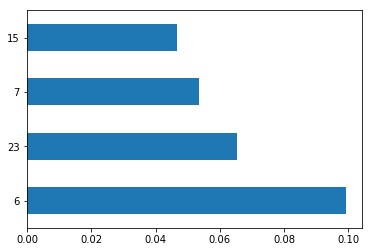

In [38]:
# X = array of feautures and y = target variable
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
# print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_)
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

In [34]:
import sys
display(X.shape)

(219, 25)